<a href="https://colab.research.google.com/github/qkrtnwjd4212/Time_Series_Data_Project/blob/main/TA_Feature_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install backtesting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.4/191.4 kB 6.5 MB/s eta 0:00:00


In [ ]:
#gdrive 마운트
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd "/content/gdrive/MyDrive/Colab Notebooks/stock"

/content/gdrive/MyDrive/Colab Notebooks/stock


In [ ]:
ls

 All_TA_signals.csv   TA_Feature_Selection.ipynb  '초기 feature 코드 '
 TA_data_30.csv      'TA signal data.ipynb'


In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

from backtesting import Backtest, Strategy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# 시그널 + TA 데이터 로드 & 병합
signals = pd.read_csv("All_TA_signals.csv", parse_dates=["Date"])
prices = pd.read_csv("TA_data_30.csv", parse_dates=["Date"])

# 2) 병합: signals + 원가격(O/H/L/C/V)
df = (
    signals
    .merge(
       prices[["Date","Ticker","Open","High","Low","Close","Volume"]],
       on=["Date","Ticker"], how="left"
    )
    .dropna(subset=["Open","High","Low","Close","Volume"])  # 병합 실패 행 제거
    .sort_values(["Ticker","Date"])
)

# train/test 분리 (21년~23년 데이터로 학습, 24년 데이터로 백테스트)
train = df[df["Date"] < "2024-01-01"].copy()
test  = df[df["Date"] >= "2024-01-01"].copy()

# 각 종목의 다음날 수익률과 target 생성
for ds in (train, test):
    ds["return"] = ds.groupby("Ticker")["Adj Close"].pct_change().shift(-1)
    ds.dropna(subset=["return"], inplace=True)
    ds["target"] = (ds["return"] > 0).astype(int)  # 1: 다음날 상승, 0: 하락/보합

        feature  importance
28   DPO_signal    0.194774
13  TRIX_signal    0.046169
7     DI_signal    0.041524
10   ROC_signal    0.036520
5   MACD_signal    0.035936
4   TEMA_signal    0.035561
11   CCI_signal    0.034644
21  NATR_signal    0.033674
18   BBB_signal    0.033545
24    AD_signal    0.033007


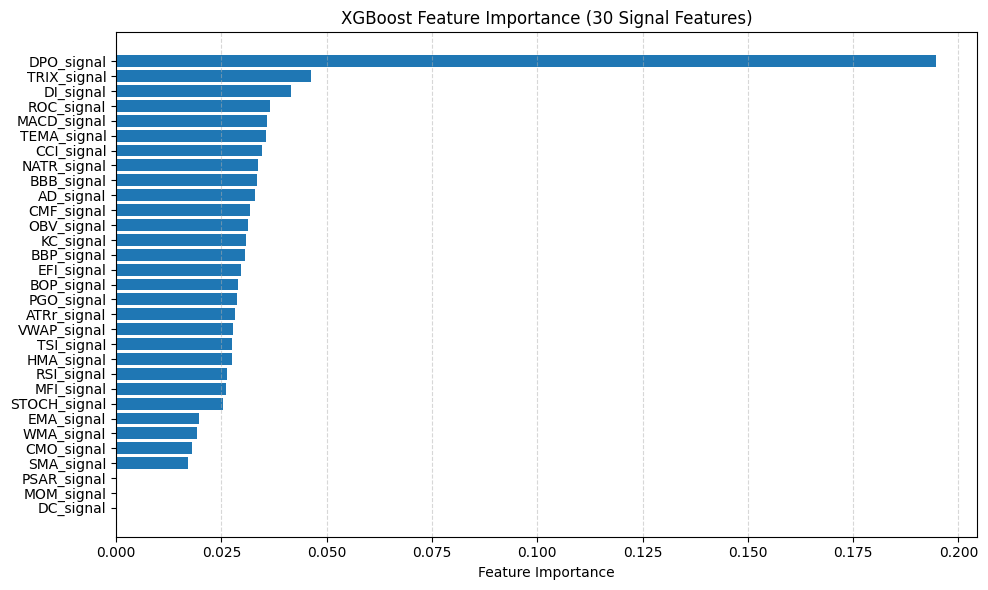

In [16]:
signal_cols = [c for c in df.columns if c.endswith("_signal")]
model = xgb.XGBClassifier(eval_metric="logloss")
model.fit(train[signal_cols], train["target"])

importances = model.feature_importances_
importance_df = pd.DataFrame({
    "feature": signal_cols,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(importance_df.head(10))

plt.figure(figsize=(10, 6))
plt.barh(importance_df["feature"], importance_df["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance (30 Signal Features)")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# 백테스트용 Strategy
class SignalStrategy(Strategy):
    signal_col = None  # 사용할 시그널 컬럼 이름

    def init(self):
        self.sig = self.data.df[self.signal_col]  # 시그널 시리즈 저장

    def next(self):
        s = self.sig.iloc[-1]  # 가장 최근 시그널

        # -1: 매수 시그널 (보유 중이 아니라면 매수)
        if s == -1 and not self.position:
            self.buy()

        # 1: 매도 시그널 (보유 중이라면 청산)
        elif s == 1 and self.position:
            self.position.close()

In [ ]:
# 3) 각 feature별 학습→예측→백테스트
results = {}
signal_cols = [c for c in df.columns if c.endswith("_signal")]

for feat in signal_cols:
    # 3-1) XGB 모델 학습
    model = xgb.XGBClassifier(eval_metric="logloss")
    model.fit(train[[feat]], train["target"])

    # 3-2) 테스트 구간에 대한 시그널 예측 (0 or 1)
    raw_preds = model.predict(test[[feat]])

    # 전략에서 사용하는 시그널 형식에 맞게 변환
    # 예측이 1(상승 예상) → -1 (매수)
    # 예측이 0(하락 예상) →  1 (매도)
    mapped_preds = np.where(raw_preds == 1, -1, 1)

    # 변환된 시그널 저장
    pred_col = f"{feat}_pred"
    test[pred_col] = mapped_preds


    # 3-3) 종목별 백테스트
    cumrets = []
    for ticker in test["Ticker"].unique():
        df_t = test[test["Ticker"] == ticker].copy()
        if df_t.empty:
            continue

        # 백테스트용 DataFrame
        bt_df = df_t.set_index("Date", drop=False)[
            ["Open","High","Low","Close","Volume", f"{feat}_pred"]
        ]
        SignalStrategy.signal_col = f"{feat}_pred"

        bt = Backtest(
            bt_df,
            SignalStrategy,
            cash=100_000,
            commission=0.001,
            trade_on_close=True,
            exclusive_orders=True
        )
        stats = bt.run()
        # 연간 수익율 % → 소수로 변환
        cumrets.append(stats["Return [%]"] / 100)

    # 종목별 평균 수익률 저장
    if cumrets:
        results[feat] = sum(cumrets) / len(cumrets)


print("학습 완료!!")

In [ ]:
print("최종 수익률 결과:", results)

최종 수익률 결과: {'SMA_signal': 0.12917755802898412, 'EMA_signal': 0.12917755802898412, 'WMA_signal': 0.12917755802898412, 'HMA_signal': 0.12917755802898412, 'TEMA_signal': 0.12917755802898412, 'MACD_signal': 0.12917755802898412, 'PSAR_signal': 0.12917755802898412, 'DI_signal': 0.12917755802898412, 'RSI_signal': 0.12917755802898412, 'STOCH_signal': 0.11232442866024017, 'ROC_signal': 0.12917755802898412, 'CCI_signal': 0.12917755802898412, 'MOM_signal': 0.12917755802898412, 'TRIX_signal': -0.002382241080322259, 'CMO_signal': 0.12917755802898412, 'TSI_signal': 0.12917755802898412, 'ATRr_signal': 0.12917755802898412, 'BBP_signal': 0.10264445245189671, 'BBB_signal': 0.12917755802898412, 'KC_signal': 0.12917755802898412, 'DC_signal': 0.12917755802898412, 'NATR_signal': 0.12917755802898412, 'OBV_signal': 0.12917755802898412, 'MFI_signal': 0.12917755802898412, 'AD_signal': 0.12917755802898412, 'EFI_signal': 0.12917755802898412, 'CMF_signal': 0.12917755802898412, 'VWAP_signal': 0.12917755802898412, '

In [ ]:
print("시각화 대상 Features:", features)
print("수익률:", avg_returns)

시각화 대상 Features: ('SMA_signal', 'EMA_signal', 'WMA_signal', 'HMA_signal', 'TEMA_signal', 'MACD_signal', 'PSAR_signal', 'DI_signal', 'RSI_signal', 'ROC_signal', 'CCI_signal', 'MOM_signal', 'CMO_signal', 'TSI_signal', 'ATRr_signal', 'BBB_signal', 'KC_signal', 'DC_signal', 'NATR_signal', 'OBV_signal', 'MFI_signal', 'AD_signal', 'EFI_signal', 'CMF_signal', 'VWAP_signal', 'DPO_signal', 'PGO_signal', 'BOP_signal', 'STOCH_signal', 'BBP_signal', 'TRIX_signal')
수익률: (0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.12917755802898412, 0.1291775580

In [ ]:
# 전체 feature에 대해 수익률 시각화

# 전체 피처들을 수익률 기준으로 내림차순 정렬
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
features, avg_returns = zip(*sorted_results)

plt.figure(figsize=(12, 10))
plt.barh(features, avg_returns, color="skyblue")
plt.xlabel("Average Backtest Return (2024)")
plt.title("All TA Features by Backtest Return")
plt.gca().invert_yaxis()  # 수익률 높은 순서부터 위로 정렬
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/250 [00:00<?, ?bar/s]

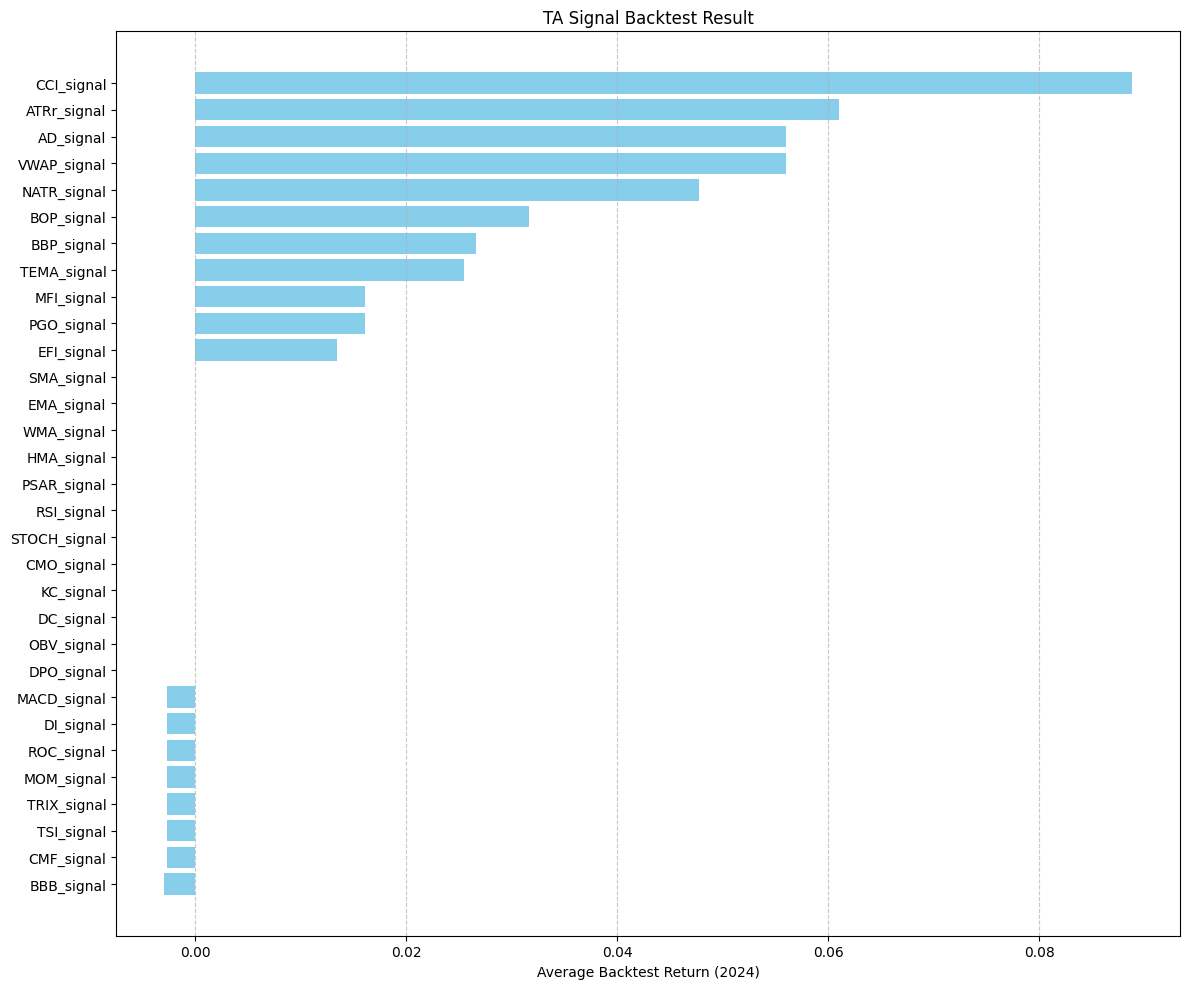

In [15]:
# ========================= 모델 학습 없이 백테스트만 진행해서 수익률 비교 =========================

# 1. 데이터 로드 및 병합
signals = pd.read_csv("All_TA_signals.csv", parse_dates=["Date"])
prices = pd.read_csv("TA_data_30.csv", parse_dates=["Date"])
df = (
    signals
    .merge(prices[["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"]],
           on=["Date", "Ticker"], how="left")
    .dropna(subset=["Open", "High", "Low", "Close", "Volume"])
    .sort_values(["Ticker", "Date"])
)

# 2. 테스트 데이터 (2024년)
test = df[df["Date"] >= "2024-01-01"].copy()

# 3. 백테스트 클래스
class RawSignalStrategy(Strategy):
    signal_col = None
    def init(self):
        self.signal = self.data.df[self.signal_col]
    def next(self):
        s = self.signal.iloc[-1]
        if s == -1 and not self.position:
            self.buy()
        elif s == 1 and self.position:
            self.position.close()

# 4. 백테스트 실행
results = {}
signal_cols = [c for c in df.columns if c.endswith("_signal")]

for feat in signal_cols:
    cumrets = []
    for ticker in test["Ticker"].unique():
        df_t = test[test["Ticker"] == ticker].copy()
        if df_t.empty: continue

        bt_df = df_t.set_index("Date", drop=False)[
            ["Open", "High", "Low", "Close", "Volume", feat]
        ]
        RawSignalStrategy.signal_col = feat
        try:
            bt = Backtest(bt_df, RawSignalStrategy, cash=100_000, commission=0.001,
                          trade_on_close=True, exclusive_orders=True)
            stats = bt.run()
            cumrets.append(stats["Return [%]"] / 100)
        except:
            continue

    if cumrets:
        results[feat] = sum(cumrets) / len(cumrets)

# 5. 시각화
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
features, avg_returns = zip(*sorted_results)

plt.figure(figsize=(12, 10))
plt.barh(features, avg_returns, color="skyblue")
plt.xlabel("Average Backtest Return (2024)")
plt.title("TA Signal Backtest Result")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()